# Earthquake Data Analysis: Bangladesh Region

This notebook analyzes earthquake patterns in and around Bangladesh to identify any unusual seismic activity patterns.

## Objectives
- Analyze temporal trends in earthquake frequency
- Examine magnitude distribution changes over time
- Assess seismic energy release patterns
- Investigate spatial clustering and depth variations
- Detect aftershock sequences and earthquake swarms
- Evaluate changes in detection capabilities

## 1. Setup and Data Loading

Import necessary libraries for data analysis, visualization, and statistical testing.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ks_2samp, poisson, kendalltau, linregress
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [50]:
# Load earthquake data from CSV
df = pd.read_csv('data/query.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018 entries, 0 to 2017
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             2018 non-null   object 
 1   latitude         2018 non-null   float64
 2   longitude        2018 non-null   float64
 3   depth            2018 non-null   float64
 4   mag              2018 non-null   float64
 5   magType          2018 non-null   object 
 6   nst              714 non-null    float64
 7   gap              1329 non-null   float64
 8   dmin             919 non-null    float64
 9   rms              1959 non-null   float64
 10  net              2018 non-null   object 
 11  id               2018 non-null   object 
 12  updated          2018 non-null   object 
 13  place            2018 non-null   object 
 14  type             2018 non-null   object 
 15  horizontalError  863 non-null    float64
 16  depthError       1349 non-null   float64
 17  magError      

### Data Preprocessing

Convert temporal data to proper datetime format and extract year for time-series analysis.

In [51]:
# Convert time column to datetime, coercing errors
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Extract year for temporal analysis
df['year'] = df['time'].dt.year

### Geographic Filtering

Filter data to focus on Bangladesh and surrounding region:
- **Latitude range**: 20.0°N to 26.9°N
- **Longitude range**: 87.5°E to 93.0°E

Total earthquakes in filtered region: 465


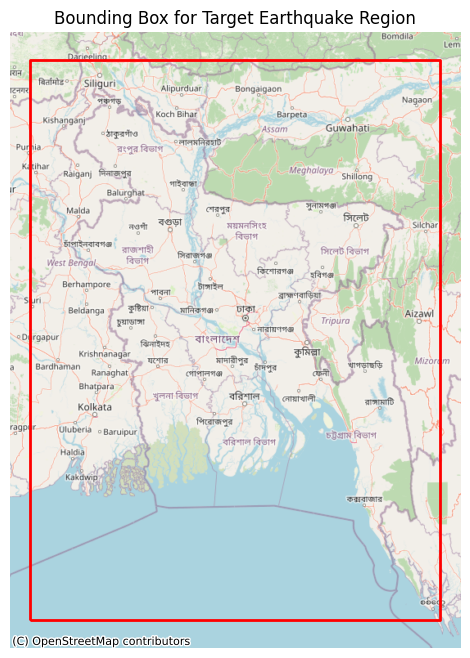

In [52]:
# Define region bounding box for Bangladesh and nearby areas
min_lat, max_lat = 20.0, 26.9
min_lon, max_lon = 87.5, 93.0

region_df = df[
    (df['latitude'].between(min_lat, max_lat)) &
    (df['longitude'].between(min_lon, max_lon))
].copy()

print("Total earthquakes in filtered region:", len(region_df))

# Create a polygon for the bounding box to visualize it
poly = Polygon([
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
])

# Create a GeoDataFrame for the polygon
poly_gdf = gpd.GeoDataFrame(index=[0], geometry=[poly], crs="EPSG:4326")

# Convert to Web Mercator for plotting with basemap tiles
poly_gdf_3857 = poly_gdf.to_crs("EPSG:3857")

# Plot the bounding box on a map
fig, ax = plt.subplots(figsize=(8, 8))
poly_gdf_3857.boundary.plot(ax=ax, edgecolor='red', linewidth=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Bounding Box for Target Earthquake Region")
ax.axis("off")
plt.show()

## 2. Data Validation

Verify that we're analyzing the correct geographic region by visualizing recent significant earthquakes.

**What to look for:**
- Earthquakes should cluster within the defined bounding box.
- Verify the spatial extent matches expectations.
- Check for any obvious data quality issues.

In [53]:
# Visualize recent significant earthquakes (e.g., year 2025, magnitude >= 5)
# Note: This may be empty if no such events occurred in the dataset for that year.
filtered_data = region_df[(region_df['mag'] >= 5) & (region_df['year'] == 2025)]

fig = px.scatter_geo(filtered_data,
                     lat='latitude',
                     lon='longitude',
                     size='mag',
                     hover_name='place',
                     projection='natural earth',
                     title='Data Validation: Earthquakes (Mag >= 5) in 2025')
fig.update_traces(marker=dict(
    colorscale='Viridis',
    color=filtered_data['mag'],
    colorbar=dict(title='Magnitude'),
    showscale=True
))
fig.update_geos(showland=True, landcolor="LightGreen", showocean=True, oceancolor="LightBlue")
fig.show()

## 3. Temporal Trend Analysis

### 3.1 Earthquake Frequency Over Time

**Research Question:** Has the number of earthquakes changed significantly over time?

**What to look for:**
- **Upward trend**: Could indicate increased seismic activity or improved detection.
- **Downward trend**: May suggest decreased activity or changes in reporting.
- **Sudden spikes**: Could indicate aftershock sequences or earthquake swarms.
- **Steady pattern**: Suggests consistent seismic activity or detection capability.

**Interpretation notes:**
- Compare recent years against the long-term average.
- Consider whether changes are gradual or abrupt.
- Account for potential improvements in detection technology.


Yearly earthquake counts:
 year
1976     1
1977     4
1978     5
1979     7
1980     3
1981     1
1982    12
1983     4
1984     5
1985     2
1986     6
1987     2
1988     6
1989     8
1990     8
1991     9
1992    11
1993     3
1994    10
1995     8
1996    14
1997     6
1998     4
1999    10
2000     8
2001    16
2002     8
2003    13
2004     9
2005    13
2006    18
2007    10
2008    21
2009     9
2010     3
2011    11
2012    15
2013    11
2014    16
2015    16
2016    12
2017    11
2018    10
2019     4
2020    15
2021    24
2022     4
2023    19
2024     9
2025    11
dtype: int64


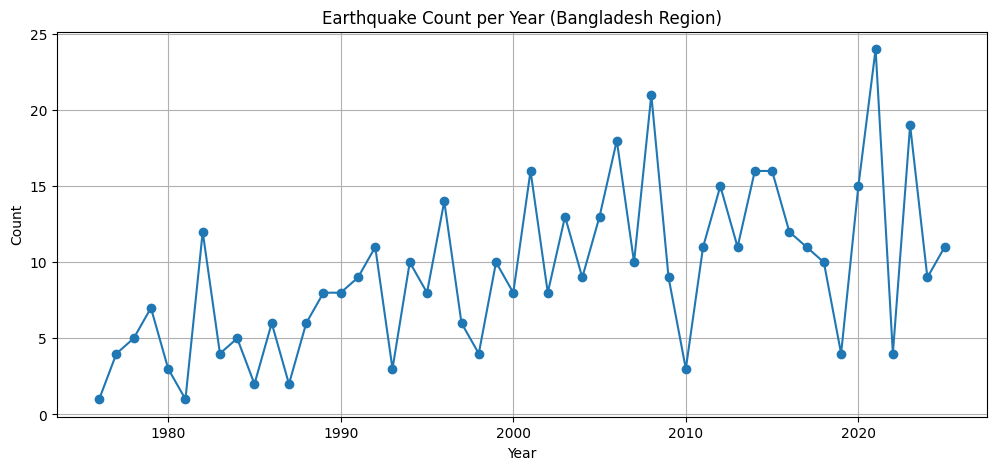

In [54]:
# Calculate and visualize yearly earthquake counts
yearly_counts = region_df.groupby('year').size()

print("\nYearly earthquake counts:\n", yearly_counts)

plt.figure(figsize=(12,5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title("Earthquake Count per Year (Bangladesh Region)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 4. Magnitude Distribution Analysis

### 4.1 Magnitude Ranges Over Time

**Research Question:** Has the distribution of earthquake magnitudes changed?

**What to look for:**
- **Increased proportion of larger quakes**: May indicate heightened seismic risk.
- **More small earthquakes detected**: Could reflect improved sensor coverage.
- **Shifts in magnitude bins**: Look for changes in the frequency of moderate (M4-5) vs strong (M5+) events.
- **Consistent patterns**: Suggests stable detection and reporting.

**Key magnitude thresholds:**
- M < 3: Minor (often not felt)
- M 3-4: Light (generally felt, rarely causes damage)
- M 4-5: Moderate (noticeable shaking, minor damage possible)
- M 5-6: Strong (can cause significant damage)
- M > 6: Major to great (serious damage potential)


Yearly earthquake counts by magnitude bins:
 year           1976  1977  1978  1979  1980  1981  1982  1983  1984  1985  \
magnitude_bin                                                               
(0, 3]            0     0     0     0     0     0     0     0     0     0   
(3, 4]            0     0     0     0     0     0     0     0     0     0   
(4, 5]            0     2     5     6     3     1    11     2     1     2   
(5, 6]            1     2     0     1     0     0     1     2     4     0   
(6, 8]            0     0     0     0     0     0     0     0     0     0   
(8, 10]           0     0     0     0     0     0     0     0     0     0   

year           ...  2016  2017  2018  2019  2020  2021  2022  2023  2024  2025  
magnitude_bin  ...                                                              
(0, 3]         ...     0     0     0     0     0     0     0     0     0     0  
(3, 4]         ...     2     0     3     1     2     3     1     1     0     1  
(4, 5]       

/var/folders/xt/8vlf86b12sj97ydvhg75641r0000gn/T/ipykernel_85444/1057575798.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



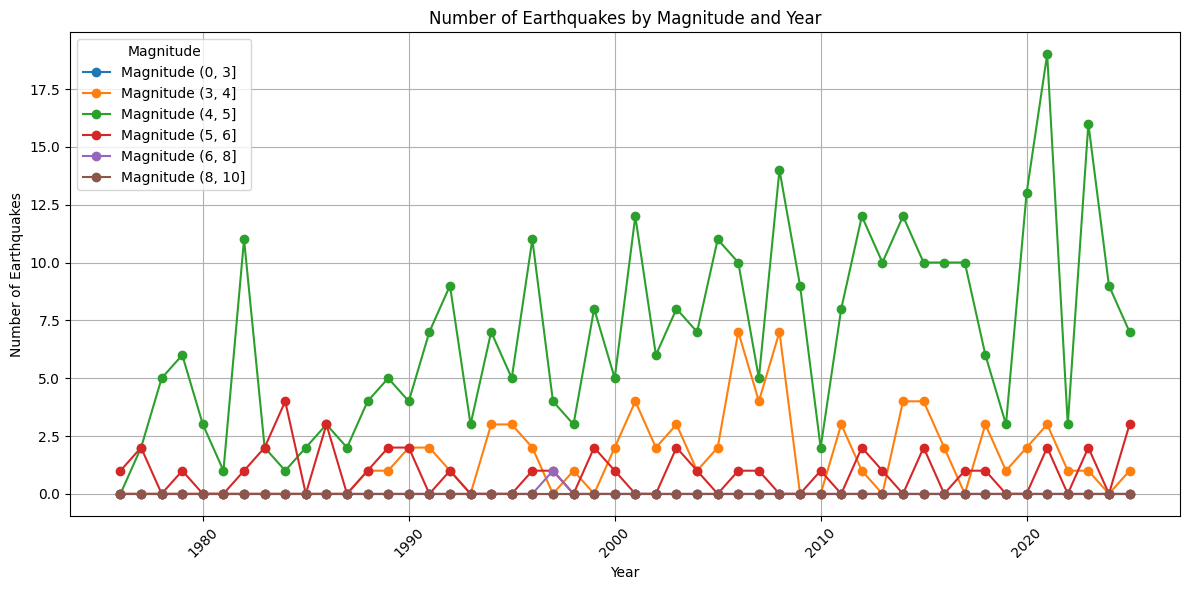

In [55]:
# Analyze earthquake counts by magnitude range and year
magnitude_bins = [0, 3, 4, 5, 6, 8, 10]
region_df['magnitude_bin'] = pd.cut(region_df['mag'], bins=magnitude_bins)
magnitude_yearly_counts = region_df.groupby(['magnitude_bin', 'year']).size().unstack(fill_value=0)

print("\nYearly earthquake counts by magnitude bins:\n", magnitude_yearly_counts)

plt.figure(figsize=(12, 6))
for mag_bin in magnitude_yearly_counts.index:
    plt.plot(magnitude_yearly_counts.columns, magnitude_yearly_counts.loc[mag_bin], marker='o', label=f'Magnitude {mag_bin}')
plt.title('Number of Earthquakes by Magnitude and Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Magnitude')
plt.tight_layout()
plt.show()

### 4.2 Magnitude Distribution Statistics

**What to look for:**
- **Mean/median changes**: Rising values suggest stronger earthquakes on average.
- **Standard deviation**: Higher values indicate more variability in magnitudes.
- **Maximum magnitude**: Track the strongest event each year.
- **Outliers in boxplot**: Unusually strong or weak events for a given year.

**Statistical significance:**
- Year-to-year variations are normal.
- Look for persistent multi-year trends rather than single-year anomalies.


Magnitude distribution stats per year:
          mean   50%       std  min  max
year                                    
1976  5.300000  5.30       NaN  5.3  5.3
1977  5.075000  4.95  0.450000  4.7  5.7
1978  4.640000  4.60  0.167332  4.4  4.8
1979  4.671429  4.70  0.303942  4.2  5.1
1980  4.766667  4.80  0.251661  4.5  5.0
1981  4.200000  4.20       NaN  4.2  4.2
1982  4.708333  4.70  0.246644  4.2  5.1
1983  4.875000  5.00  0.403113  4.3  5.2
1984  5.260000  5.20  0.472229  4.7  6.0
1985  4.800000  4.80  0.141421  4.7  4.9
1986  5.033333  5.00  0.301109  4.7  5.4
1987  4.500000  4.50  0.141421  4.4  4.6
1988  4.633333  4.55  0.665332  4.0  5.9
1989  4.650000  4.45  0.656832  4.0  5.8
1990  4.575000  4.65  0.567576  3.8  5.2
1991  4.566667  4.70  0.400000  3.8  5.0
1992  4.472727  4.30  0.438385  4.0  5.3
1993  4.333333  4.30  0.152753  4.2  4.5
1994  4.300000  4.35  0.355903  3.7  4.8
1995  4.162500  4.20  0.244584  3.8  4.4
1996  4.364286  4.30  0.397312  3.8  5.4
1997  5.150000  4

<Figure size 1200x600 with 0 Axes>

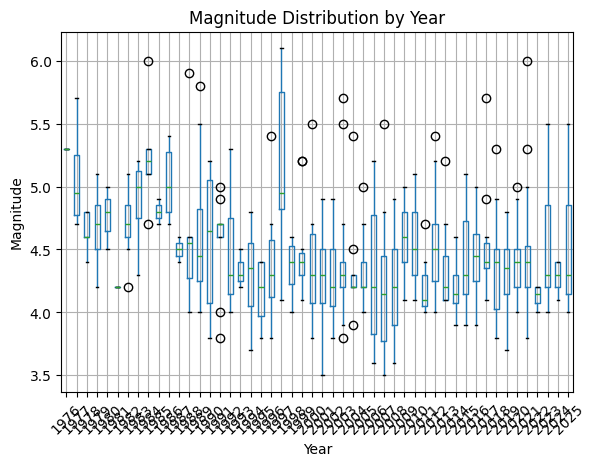

In [56]:
# Statistical summary and boxplot of magnitude distributions by year
mag_by_year = region_df.groupby('year')['mag']

print("\nMagnitude distribution stats per year:")
print(mag_by_year.describe()[['mean','50%','std','min','max']])

# Boxplot for visual comparison
plt.figure(figsize=(12,6))
region_df.boxplot(column='mag', by='year')
plt.title("Magnitude Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylabel("Magnitude")
plt.show()

### 4.3 Geographic Distribution of Magnitudes

**What to look for:**
- **Spatial clustering**: Are strong earthquakes concentrated in specific areas?
- **Geographic patterns**: Identify active fault zones or subduction zones.
- **Distribution changes**: Compare current patterns to historical data using the animation slider.
- **Color intensity**: Warmer colors indicate stronger magnitudes.

In [57]:
fig = px.scatter_geo(
    region_df,
    lat='latitude',
    lon='longitude',
    animation_frame='year',
    size='mag',                     # circle size = magnitude
    color='mag',                    # color = magnitude
    hover_name='place',
    projection='natural earth',
    title='Earthquakes in and around Bangladesh (Scaled by Magnitude)',
    color_continuous_scale='Turbo',
)

# Improve marker styling
fig.update_traces(
    marker=dict(
        line=dict(width=0.5, color='black'),
        sizeref=0.5,               # adjusts scaling
        sizemin=3
    )
)

# Focus the map on target bounding box
fig.update_geos(
    showcountries=True,
    showland=True,
    landcolor="#f0efe3",
    oceancolor="#c9e6ff",
    showocean=True,
    showsubunits=True,
    fitbounds="locations",          # zoom automatically to target points
)

fig.show()


## 5. Seismic Energy Analysis

### Total Energy Release

**Research Question:** Has the total seismic energy released changed over time?

**Background:** 
- Earthquake magnitude is logarithmic: each unit increase represents ~31.6× more energy.
- One M7 earthquake releases more energy than thousands of M4 earthquakes.
- Energy formula: log₁₀(E) ≈ 1.5M + 4.8 (Gutenberg-Richter relation).

**What to look for:**
- **Energy spikes**: Usually caused by one or more large earthquakes.
- **Long-term trends**: Gradual increases may indicate heightened tectonic stress.
- **Recent vs. historical**: Compare current year against multi-year average.
- **Dominant events**: A single large quake can dominate annual energy totals.

**Interpretation:**
- High energy with low event count = few large earthquakes.
- High energy with high event count = many moderate earthquakes or a major event.


Total seismic energy per year (Joules):
 year
1976    5.623413e+12
1977    2.691354e+13
1978    3.253563e+12
1979    6.817135e+12
1980    3.350076e+12
1981    1.258925e+11
1982    1.191701e+13
1983    8.389820e+12
1984    7.622655e+13
1985    2.120483e+12
1986    2.025571e+13
1987    7.523759e+11
1988    4.621454e+13
1989    4.435321e+13
1990    1.180498e+13
1991    6.835489e+12
1992    1.099452e+13
1993    6.585339e+11
1994    3.145382e+12
1995    1.159906e+12
1996    1.112159e+13
1997    1.567178e+14
1998    1.096924e+12
1999    9.641196e+12
2000    1.299024e+13
2001    4.217587e+12
2002    2.554534e+12
2003    3.579731e+13
2004    9.201990e+12
2005    4.566894e+12
2006    1.131795e+13
2007    1.308693e+13
2008    6.976155e+12
2009    6.730007e+12
2010    3.262321e+12
2011    1.882003e+12
2012    1.778286e+13
2013    6.029198e+12
2014    2.430979e+12
2015    1.011631e+13
2016    5.572075e+12
2017    2.610529e+13
2018    8.463421e+12
2019    1.451404e+12
2020    6.085331e+12
2021    

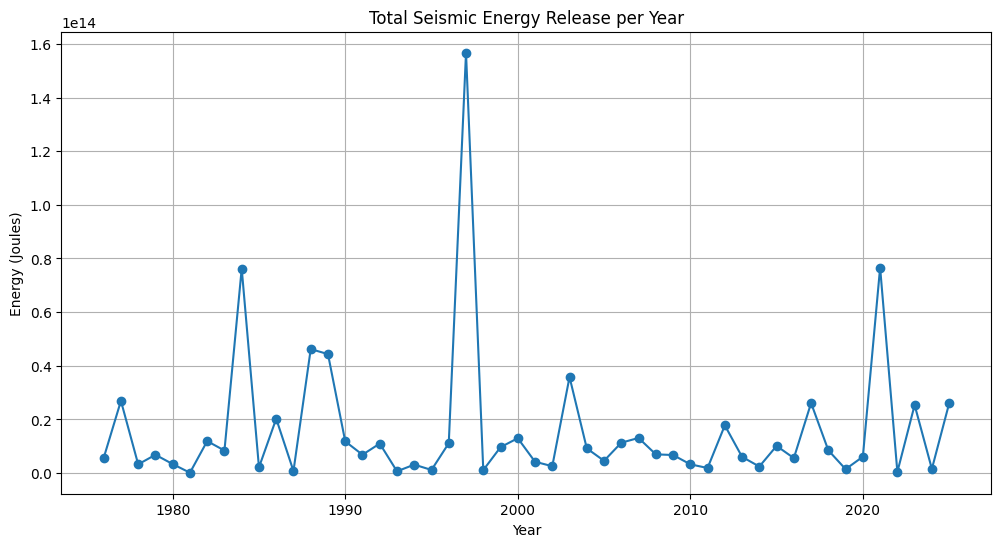

In [58]:
# Calculate and plot total seismic energy release per year
# Using the Gutenberg–Richter energy relation: log10(E) ≈ 1.5M + 4.8
region_df['energy_joules'] = 10 ** (1.5 * region_df['mag'] + 4.8)

energy_by_year = region_df.groupby('year')['energy_joules'].sum()

print("\nTotal seismic energy per year (Joules):\n", energy_by_year)

plt.figure(figsize=(12,6))
plt.plot(energy_by_year.index, energy_by_year.values, marker='o')
plt.title("Total Seismic Energy Release per Year")
plt.xlabel("Year")
plt.ylabel("Energy (Joules)")
plt.grid(True)
plt.show()

## 6. Depth Distribution Analysis

### Earthquake Depth Patterns

**Research Question:** Are earthquakes occurring at different depths than usual?

**Background:**
- **Shallow (<70 km)**: Crustal earthquakes, typically most damaging.
- **Intermediate (70-300 km)**: Subduction zone earthquakes.
- **Deep (>300 km)**: Deep subduction zone earthquakes, rarely felt at surface.

**What to look for:**
- **Depth shifts**: Changes in average/median depth may indicate different seismic sources.
- **Shallow clustering**: More shallow quakes can mean higher surface damage risk.
- **Depth range expansion**: New depth ranges may indicate activation of different fault systems.
- **Outliers**: Unusually deep or shallow events warrant investigation.

**Regional context:**
- Bangladesh region experiences mainly shallow to intermediate depth earthquakes.
- Himalayan collision zone produces mostly shallow crustal quakes.
- Subduction zones (if present) produce deeper events.


Depth distribution stats per year:
           mean     50%        std    min      max
year                                              
1976  23.000000  23.000        NaN  23.00   23.000
1977  37.000000  36.500   4.690416  33.00   42.000
1978  40.000000  39.000   9.000000  33.00   55.000
1979  34.285714  33.000  15.184579  18.00   66.000
1980  33.000000  33.000   0.000000  33.00   33.000
1981  33.000000  33.000        NaN  33.00   33.000
1982  36.208333  33.000   8.990142  33.00   63.900
1983  27.250000  33.000  11.500000  10.00   33.000
1984  39.140000  33.000  20.055373  22.60   74.100
1985  27.600000  27.600   7.495332  22.30   32.900
1986  35.816667  36.000  10.921065  17.50   49.300
1987  43.800000  43.800  15.273506  33.00   54.600
1988  33.366667  33.000   3.337464  28.90   39.300
1989  42.900000  33.000  29.966696   5.80  104.500
1990  52.000000  33.000  42.430885  33.00  155.700
1991  38.022222  33.000  15.066667  33.00   78.200
1992  36.836364  33.000   8.088420  29.30   54

<Figure size 1200x500 with 0 Axes>

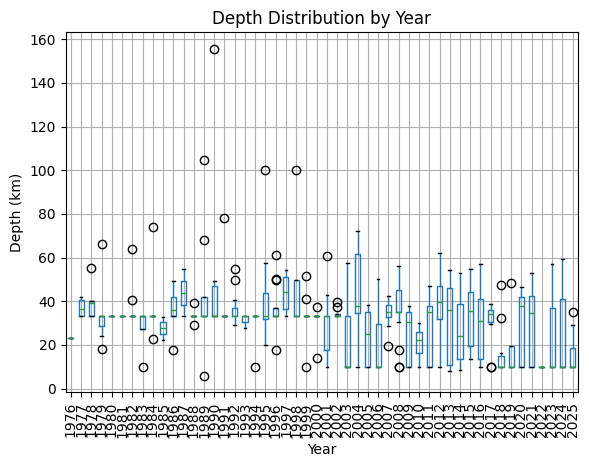

In [59]:
# Analyze depth distribution statistics and visualize with boxplots
depth_by_year = region_df.groupby('year')['depth']

print("\nDepth distribution stats per year:")
print(depth_by_year.describe()[['mean','50%','std','min','max']])

plt.figure(figsize=(12,5))
region_df.boxplot(column='depth', by='year')
plt.title("Depth Distribution by Year")
plt.suptitle("")
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Depth (km)")
plt.show()

### 6.1 Are earthquakes getting shallower?

Here we analyze the trend of earthquake depths over time. We look at the median depth and the fraction of shallow earthquakes (<40 km) per year.

**Interpretation Guide:**
- If median depth decreases (plot goes up) and the linear regression slope is negative → earthquakes are getting shallower.
- If the fraction of shallow earthquakes is rising → more events are occurring closer to the surface.
- If the Mann-Kendall p-value is < 0.05 → the trend is statistically significant.


Fraction of Shallow Earthquakes (<40 km) by Year:
 year
1976    1.000000
1977    0.500000
1978    0.600000
1979    0.857143
1980    1.000000
1981    1.000000
1982    0.833333
1983    1.000000
1984    0.800000
1985    1.000000
1986    0.666667
1987    0.500000
1988    1.000000
1989    0.750000
1990    0.625000
1991    0.888889
1992    0.727273
1993    1.000000
1994    1.000000
1995    0.750000
1996    0.785714
1997    0.333333
1998    0.750000
1999    0.800000
2000    1.000000
2001    0.875000
2002    1.000000
2003    0.846154
2004    0.555556
2005    1.000000
2006    0.777778
2007    0.800000
2008    0.619048
2009    1.000000
2010    1.000000
2011    0.818182
2012    0.533333
2013    0.636364
2014    0.750000
2015    0.625000
2016    0.750000
2017    1.000000
2018    0.900000
2019    0.750000
2020    0.733333
2021    0.708333
2022    1.000000
2023    0.789474
2024    0.666667
2025    1.000000
Name: is_shallow, dtype: float64


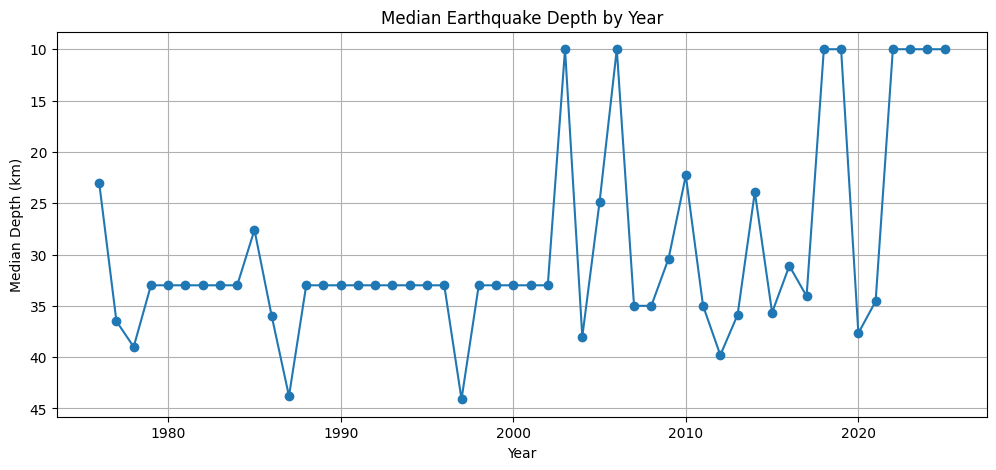

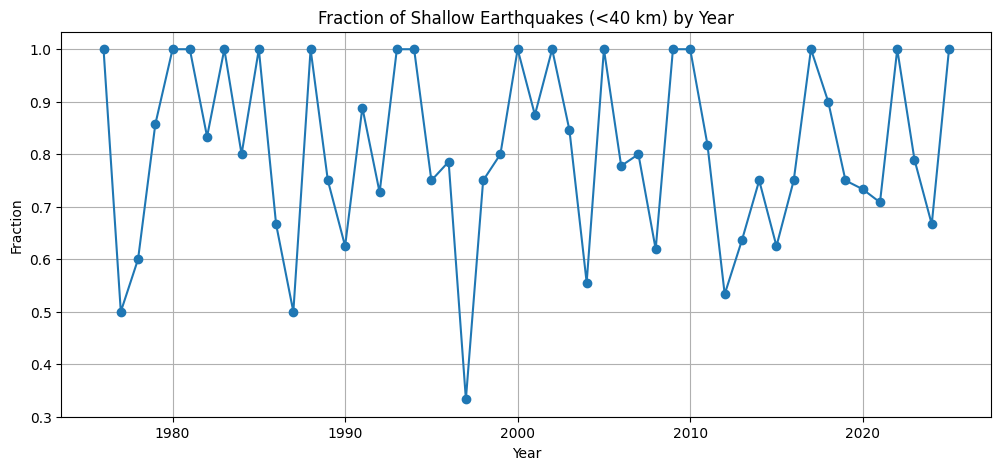

In [60]:
# Calculate median depth per year
median_depth_by_year = region_df.groupby("year")["depth"].median()

# Calculate the fraction of shallow earthquakes (<40 km) per year
region_df["is_shallow"] = region_df["depth"] < 40
shallow_fraction = region_df.groupby("year")["is_shallow"].mean()

print("\nFraction of Shallow Earthquakes (<40 km) by Year:\n", shallow_fraction)

# --- Plot Median Depth ---
plt.figure(figsize=(12, 5))
plt.plot(median_depth_by_year.index, median_depth_by_year.values, marker='o')
plt.gca().invert_yaxis()  # Invert y-axis so shallower depths are higher
plt.title("Median Earthquake Depth by Year")
plt.xlabel("Year")
plt.ylabel("Median Depth (km)")
plt.grid(True)
plt.show()

# --- Plot Fraction of Shallow Quakes ---
plt.figure(figsize=(12, 5))
plt.plot(shallow_fraction.index, shallow_fraction.values, marker='o')
plt.title("Fraction of Shallow Earthquakes (<40 km) by Year")
plt.xlabel("Year")
plt.ylabel("Fraction")
plt.grid(True)
plt.show()

### 6.2 Statistical Trend Tests for Depth

We use two statistical tests to determine if the trend in median depth is significant.

1.  **Mann-Kendall Test**: A non-parametric test for monotonic trends (consistently increasing or decreasing).
2.  **Linear Regression**: Fits a straight line to the data to quantify the trend's slope.

In [61]:
# Prepare data for trend tests
years = median_depth_by_year.index.values
median_depth_values = median_depth_by_year.values

# --- Mann–Kendall Trend Test ---
tau, p_mk = kendalltau(years, median_depth_values)

print("----- Mann–Kendall Trend Test for Median Depth -----")
print(f"Tau = {tau:.3f}")
print(f"p-value = {p_mk:.3f}")
if p_mk < 0.05:
    trend_direction = "decreasing (shallowing)" if tau < 0 else "increasing (deepening)"
    print(f"Significant monotonic trend detected: depth is {trend_direction}.")
else:
    print("No statistically significant monotonic trend detected.")

# --- Linear Regression Trend ---
reg = linregress(years, median_depth_values)

print("\n----- Linear Regression Trend for Median Depth -----")
print(f"Slope (km/year) = {reg.slope:.3f}")
print(f"p-value = {reg.pvalue:.3f}")
print(f"R² = {reg.rvalue**2:.3f}")

if reg.pvalue < 0.05:
    if reg.slope < 0:
        print("Result: Depth is significantly decreasing over time (earthquakes are getting shallower).")
    else:
        print("Result: Depth is significantly increasing over time (earthquakes are getting deeper).")
else:
    print("Result: No statistically significant linear trend in depth over time.")

----- Mann–Kendall Trend Test for Median Depth -----
Tau = -0.191
p-value = 0.066
No statistically significant monotonic trend detected.

----- Linear Regression Trend for Median Depth -----
Slope (km/year) = -0.307
p-value = 0.001
R² = 0.218
Result: Depth is significantly decreasing over time (earthquakes are getting shallower).


## 7. Spatial and Temporal Clustering

### 7.1 Kernel Density Estimation (KDE)

**Research Question:** Are earthquakes clustering differently in space this year compared to previous years?

**What to look for:**
- **Density hotspots**: Areas of concentrated seismic activity.
- **New clusters**: Emergence of activity in previously quiet areas.
- **Cluster migration**: Shifts in activity centers over time.
- **Intensity changes**: Stronger colors indicate higher earthquake density.

**Interpretation:**
- Tight clustering may indicate:
  - Earthquake swarms (many similar-sized events)
  - Aftershock sequences (following a large mainshock)
  - Localized tectonic stress concentration
- Diffuse patterns suggest regional tectonic activity.

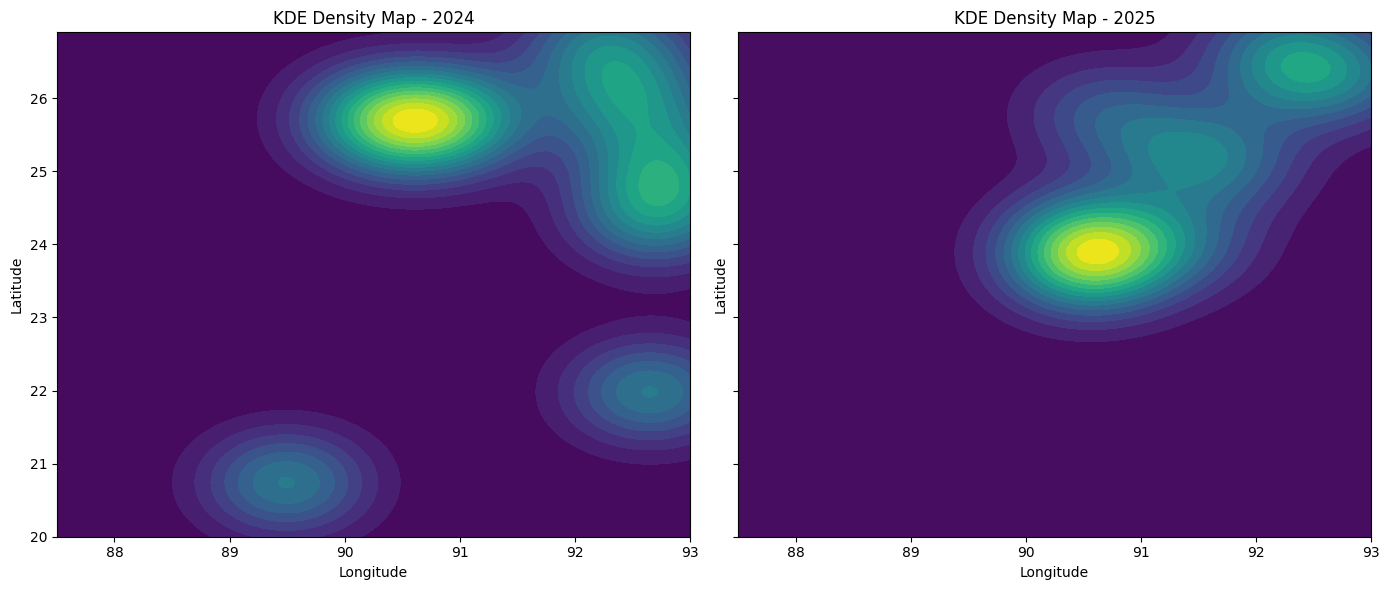

In [62]:
# Define current and previous years for comparison
current_year = region_df['year'].max()
previous_year = current_year - 1

# Create a KDE model for each year to compare clustering
kde_years = {}
for y in [previous_year, current_year]:
    pts = region_df[region_df['year'] == y][['longitude', 'latitude']].values
    if len(pts) > 2: # KDE requires at least 3 points
        kde_years[y] = KernelDensity(bandwidth=0.5, kernel='gaussian').fit(pts)

def plot_kde(year, ax):
    if year not in kde_years:
        ax.text(0.5, 0.5, f"No KDE for {year}", ha='center')
        ax.set_title(f"KDE Density Map - {year}")
        return

    kde = kde_years[year]
    lon_lin = np.linspace(min_lon, max_lon, 200)
    lat_lin = np.linspace(min_lat, max_lat, 200)
    xx, yy = np.meshgrid(lon_lin, lat_lin)
    grid = np.vstack([xx.ravel(), yy.ravel()]).T

    zz = np.exp(kde.score_samples(grid)).reshape(xx.shape)
    ax.contourf(xx, yy, zz, levels=20)
    ax.set_title(f"KDE Density Map - {year}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
plot_kde(previous_year, axs[0])
plot_kde(current_year, axs[1])
plt.tight_layout()
plt.show()

### 7.2 KDE with Basemap

This plot provides better geographic context by overlaying the density map on an OpenStreetMap basemap.

**Note on Bandwidth:** The `bandwidth` parameter for KDE is crucial. Here it's set in meters because we are using a projected coordinate system (Web Mercator, EPSG:3857). It may require tuning for optimal visualization.

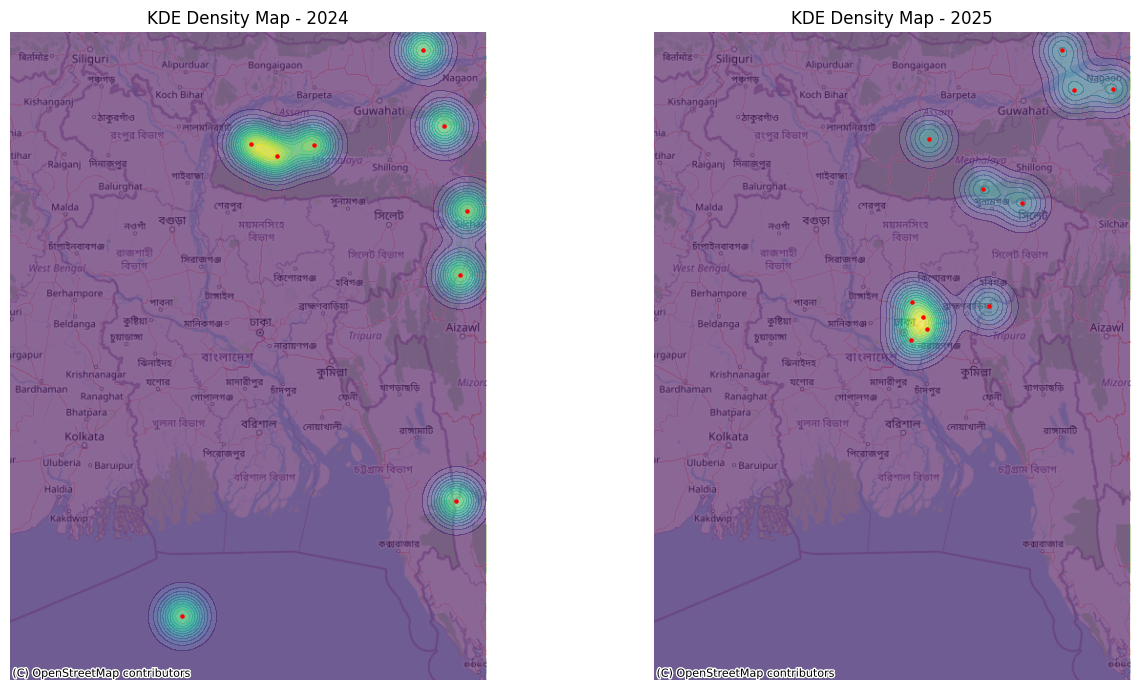

In [63]:
# Convert DataFrame to GeoDataFrame for spatial analysis and plotting
gdf = gpd.GeoDataFrame(
    region_df,
    geometry=gpd.points_from_xy(region_df.longitude, region_df.latitude),
    crs="EPSG:4326"
).to_crs("EPSG:3857")  # Project to Web Mercator for basemaps

# Re-calculate KDEs in projected coordinates
kde_years_proj = {}
for y in [previous_year, current_year]:
    # Extract projected coordinates
    pts = np.vstack([gdf[gdf['year']==y].geometry.x,
                     gdf[gdf['year']==y].geometry.y]).T
    if len(pts) > 2:
        # Bandwidth is now in meters, requires tuning (e.g., 20km = 20000)
        kde_years_proj[y] = KernelDensity(bandwidth=20000, kernel='gaussian').fit(pts)

def plot_kde_map(year, ax):
    if year not in kde_years_proj:
        ax.text(0.5, 0.5, f"No KDE for {year}", ha='center', transform=ax.transAxes)
        ax.set_title(f"KDE Density Map - {year}")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        ax.set_axis_off()
        return

    kde = kde_years_proj[year]

    # Create grid in projected coordinates
    minx, miny, maxx, maxy = gdf.total_bounds
    xx, yy = np.meshgrid(np.linspace(minx, maxx, 200), np.linspace(miny, maxy, 200))
    grid = np.vstack([xx.ravel(), yy.ravel()]).T

    zz = np.exp(kde.score_samples(grid)).reshape(xx.shape)

    # Plot density contour
    ax.contourf(xx, yy, zz, levels=15, alpha=0.6, cmap='viridis')
    # Overlay earthquake points
    gdf[gdf['year']==year].plot(ax=ax, color="red", markersize=5)
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"KDE Density Map - {year}")
    ax.axis("off")

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plot_kde_map(previous_year, axs[0])
plot_kde_map(current_year, axs[1])
plt.tight_layout()
plt.show()

## 8. Earthquake Sequences

### 8.1 Aftershock Detection

**Research Question:** Are there significant aftershock sequences following major earthquakes?

**Background:**
- Aftershocks: Smaller earthquakes following a mainshock (typically within days to weeks).
- Follow Omori's law: frequency decreases with time after mainshock.
- Typically occur within ~1-2 fault lengths of mainshock.

**Detection criteria:**
- **Mainshock threshold**: M ≥ 5.0
- **Temporal window**: 7 days after mainshock
- **Spatial window**: ±0.5° latitude/longitude (~55 km)

**What to look for:**
- **Number of sequences**: More sequences may indicate increased large earthquake activity.
- **Aftershock productivity**: Number of aftershocks per mainshock.
- **Magnitude differences**: Typical aftershocks are 1-2 magnitudes smaller than mainshock.
- **Duration**: Extended sequences may indicate continued stress release.

In [64]:
# Identify mainshocks and their associated aftershock sequences
MAINSHOCK_MAG = 5.0
mainshocks = region_df[region_df['mag'] >= MAINSHOCK_MAG]

aftershock_sequences = []
for idx, main in mainshocks.iterrows():
    # Define a temporal and spatial window to search for aftershocks
    time_window = (region_df['time'] > main['time']) & (region_df['time'] <= main['time'] + pd.Timedelta(days=7))
    lat_window = region_df['latitude'].between(main['latitude'] - 0.5, main['latitude'] + 0.5)
    lon_window = region_df['longitude'].between(main['longitude'] - 0.5, main['longitude'] + 0.5)

    window = region_df[time_window & lat_window & lon_window]

    if not window.empty:
        aftershock_sequences.append((main, window))

print(f"Detected {len(aftershock_sequences)} potential aftershock sequences.")
for main, aftershocks in aftershock_sequences:
    print(f"\nMainshock: {main['time']} Mag {main['mag']:.2f} at ({main['latitude']:.2f}, {main['longitude']:.2f})")
    print(f"  └─ Found {len(aftershocks)} aftershocks.")

Detected 10 potential aftershock sequences.

Mainshock: 2025-11-21 04:38:28.765000+00:00 Mag 5.40 at (23.81, 90.65)
  └─ Found 2 aftershocks.

Mainshock: 2021-07-07 03:15:24.246000+00:00 Mag 5.30 at (25.96, 90.35)
  └─ Found 1 aftershocks.

Mainshock: 2021-04-28 02:33:01.489000+00:00 Mag 5.00 at (26.75, 92.51)
  └─ Found 3 aftershocks.

Mainshock: 2021-04-28 02:21:26.212000+00:00 Mag 6.00 at (26.78, 92.46)
  └─ Found 4 aftershocks.

Mainshock: 2006-02-23 20:07:26.170000+00:00 Mag 5.20 at (26.86, 91.63)
  └─ Found 4 aftershocks.

Mainshock: 2003-07-27 12:07:29.430000+00:00 Mag 5.50 at (22.82, 92.34)
  └─ Found 2 aftershocks.

Mainshock: 2003-07-26 23:18:17.960000+00:00 Mag 5.70 at (22.85, 92.31)
  └─ Found 6 aftershocks.

Mainshock: 1999-10-05 17:04:44.890000+00:00 Mag 5.20 at (26.26, 91.93)
  └─ Found 1 aftershocks.

Mainshock: 1997-11-21 11:23:06.310000+00:00 Mag 6.10 at (22.21, 92.70)
  └─ Found 1 aftershocks.

Mainshock: 1982-12-30 08:37:14.390000+00:00 Mag 5.00 at (26.16, 91.64)
  

### 8.2 Earthquake Swarm Detection

**Research Question:** Are there earthquake swarms (clusters without a dominant mainshock)?

**Background:**
- Swarms differ from aftershock sequences: no single dominant mainshock.
- Events of similar magnitude occurring close together in space and time.
- Can indicate fluid migration, volcanic activity, or slow slip events.

**Method:** DBSCAN clustering algorithm
- Groups earthquakes based on spatial and temporal proximity.
- No predefined number of clusters required.
- Identifies outliers (isolated events).

**Parameters:**
- **eps (0.4)**: Maximum distance between earthquakes in a cluster (in standardized units).
- **min_samples (4)**: Minimum earthquakes to form a cluster.

**What to look for:**
- **Cluster sizes**: Larger clusters (>5 events) may be swarms.
- **Spatial tightness**: Swarms typically occur in very localized areas.
- **Magnitude distribution**: Swarms have similar-sized events (unlike aftershock sequences).
- **Temporal concentration**: Events occur over days to weeks.

Potential swarm clusters found:
cluster
0      9
1    232
2     55
3     21
5      9
7      7
dtype: int64


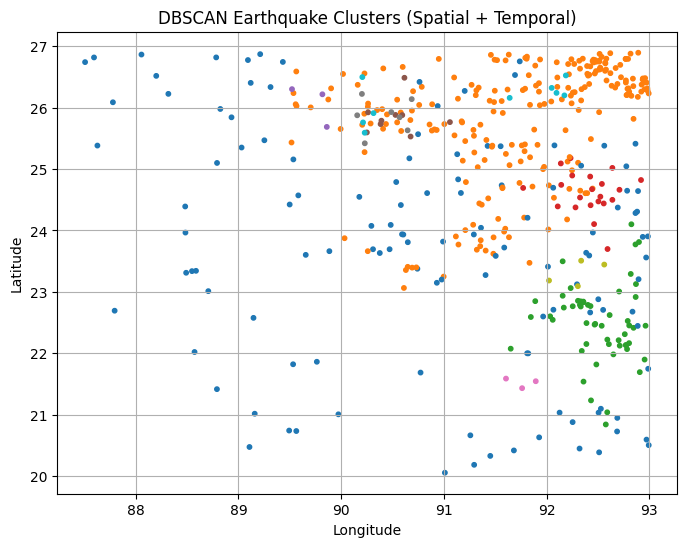

In [65]:
# Use DBSCAN to identify potential earthquake swarms

# Prepare data for clustering (spatial + temporal dimensions)
X = region_df[['latitude', 'longitude']].copy()
X['time_ordinal'] = region_df['time'].astype(np.int64) // 10**9  # convert ns to seconds
X_scaled = StandardScaler().fit_transform(X)

# Run DBSCAN (eps and min_samples may need tuning)
db = DBSCAN(eps=0.4, min_samples=4).fit(X_scaled)
region_df['cluster'] = db.labels_

# Identify and report potential swarm clusters (clusters with more than 5 events)
swarm_clusters = region_df[region_df['cluster'] != -1].groupby('cluster').size()
swarm_clusters = swarm_clusters[swarm_clusters > 5]

print("Potential swarm clusters found:")
print(swarm_clusters)

# Plot clusters on a map
plt.figure(figsize=(8,6))
plt.scatter(region_df['longitude'], region_df['latitude'], c=region_df['cluster'], cmap='tab10', s=10)
plt.title("DBSCAN Earthquake Clusters (Spatial + Temporal)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [66]:
# Prepare colors (Plotly automatically handles categorical cluster colors)
region_df['cluster_str'] = np.where(
    region_df['cluster'] == -1,
    'Noise / Not in Cluster',
    region_df['cluster'].astype(str)
)

fig = px.scatter_geo(
    region_df,
    lat='latitude',
    lon='longitude',
    color='cluster_str',
    hover_name='place',
    hover_data={'mag': True, 'depth': True, 'cluster_str': True},
    size='mag',
    size_max=15,
    projection='natural earth',
    title='DBSCAN Earthquake Swarm Clusters (Spatial + Temporal)'
)

# Style improvements
fig.update_traces(
    marker=dict(
        line=dict(width=0.5, color='black'),
        opacity=0.85
    )
)

# Focus on Bangladesh region
fig.update_geos(
    showcountries=True,
    showland=True,
    landcolor="#eef0e4",
    oceancolor="#c8e7ff",
    showocean=True,
    showsubunits=True,
)

fig.show()


### 8.3 Inter-Event Time Analysis

**Research Question:** Are earthquakes occurring closer together in time?

**What to look for:**
- **Shorter inter-event times**: May indicate:
  - Heightened seismic activity
  - Aftershock sequences
  - Earthquake swarms
- **Distribution shifts**: Compare current year histogram against previous years.
- **Median changes**: Lower median = events occurring more frequently.

**Interpretation:**
- Normal tectonic regions: Inter-event times vary widely.
- Active periods: Shorter times, leftward histogram shift.
- Quiet periods: Longer times, rightward histogram shift.
- Exponential distribution is typical for earthquake occurrence.

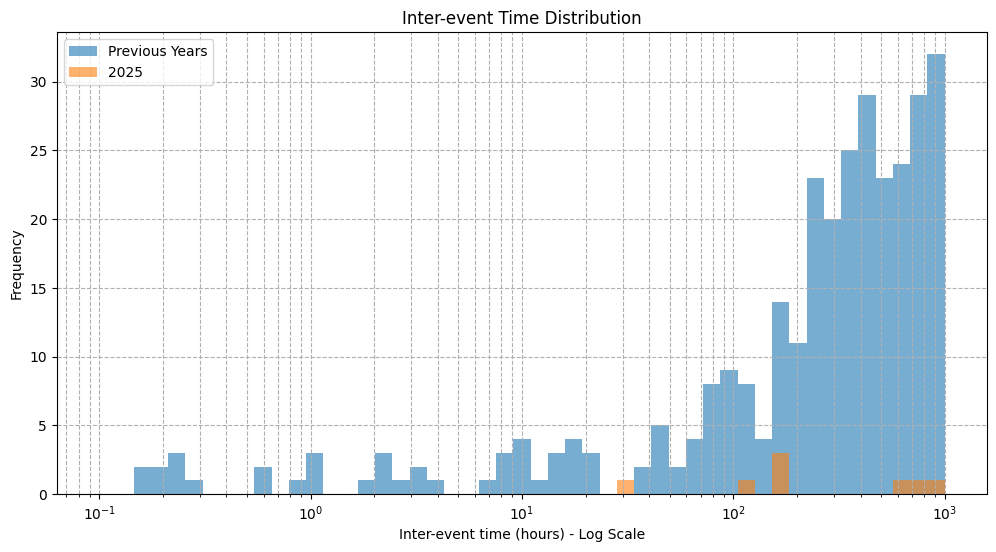

Median inter-event time (previous years): 548.5910227777778
Median inter-event time (2025): 652.5385641666666


In [67]:
# Compare inter-event time distributions between current and previous years
# Sort by time to calculate differences correctly
region_df = region_df.sort_values('time')

# Compute inter-event time deltas in hours
region_df['delta_hours'] = region_df['time'].diff().dt.total_seconds() / 3600

# Separate current year from previous years
current_df = region_df[region_df['year'] == current_year]
previous_df = region_df[region_df['year'] < current_year]

plt.figure(figsize=(12,6))
plt.hist(previous_df['delta_hours'].dropna(), bins=np.logspace(np.log10(0.1), np.log10(1000), 50), alpha=0.6, label='Previous Years')
plt.hist(current_df['delta_hours'].dropna(), bins=np.logspace(np.log10(0.1), np.log10(1000), 50), alpha=0.6, label=f'{current_year}')
plt.gca().set_xscale("log")
plt.legend()
plt.xlabel("Inter-event time (hours) - Log Scale")
plt.ylabel("Frequency")
plt.title("Inter-event Time Distribution")
plt.grid(True, which="both", ls="--")
plt.show()

print("Median inter-event time (previous years):", previous_df['delta_hours'].median())
print(f"Median inter-event time ({current_year}):", current_df['delta_hours'].median())

## 9. Detection System Analysis

### 9.1 Minimum Detectable Magnitude

**Research Question:** Has the detection threshold changed over time?

**Why this matters:**
- Improved sensors detect smaller earthquakes.
- Network expansion increases detection capability.
- An apparent increase in earthquakes may be due to better detection, not more activity.

**What to look for:**
- **Decreasing minimum magnitude**: Better detection capability over time.
- **Stable minimum**: Consistent detection threshold.
- **Sudden changes**: May indicate:
  - New seismic stations coming online
  - Network upgrades
  - Changes in reporting practices

**Interpretation:**
- If minimum magnitude drops while total counts rise → likely improved detection.
- If minimum magnitude is stable while counts rise → possibly a real increase in activity.

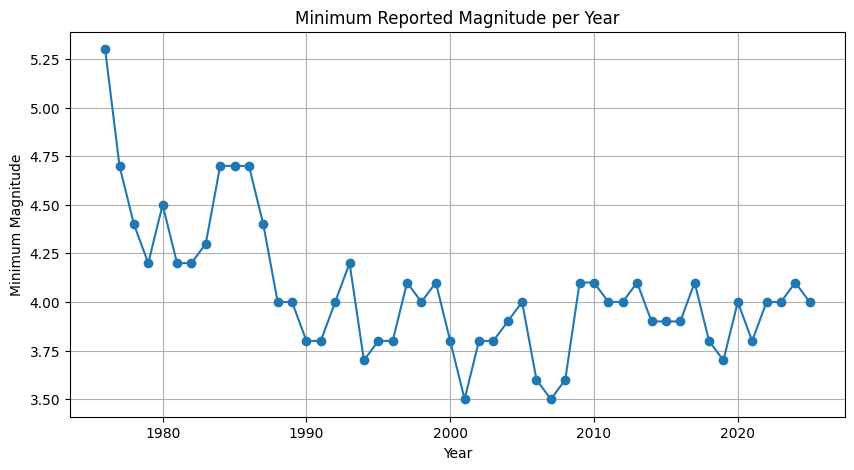

year
1976    5.3
1977    4.7
1978    4.4
1979    4.2
1980    4.5
1981    4.2
1982    4.2
1983    4.3
1984    4.7
1985    4.7
1986    4.7
1987    4.4
1988    4.0
1989    4.0
1990    3.8
1991    3.8
1992    4.0
1993    4.2
1994    3.7
1995    3.8
1996    3.8
1997    4.1
1998    4.0
1999    4.1
2000    3.8
2001    3.5
2002    3.8
2003    3.8
2004    3.9
2005    4.0
2006    3.6
2007    3.5
2008    3.6
2009    4.1
2010    4.1
2011    4.0
2012    4.0
2013    4.1
2014    3.9
2015    3.9
2016    3.9
2017    4.1
2018    3.8
2019    3.7
2020    4.0
2021    3.8
2022    4.0
2023    4.0
2024    4.1
2025    4.0
Name: mag, dtype: float64


In [68]:
# Track minimum reported magnitude per year to assess detection capability
min_mag_by_year = region_df.groupby('year')['mag'].min()

plt.figure(figsize=(10,5))
plt.plot(min_mag_by_year.index, min_mag_by_year.values, marker='o')
plt.title("Minimum Reported Magnitude per Year")
plt.xlabel("Year")
plt.ylabel("Minimum Magnitude")
plt.grid(True)
plt.show()

print(min_mag_by_year)

### 9.2 Network Coverage

**Research Question:** Has the number of reporting networks changed?

**What to look for:**
- **Increasing networks**: More stations = better detection and location accuracy.
- **Stable networks**: Consistent reporting capability.
- **Network expansion**: May explain apparent increases in earthquake counts.

**Interpretation:**
- Correlation with earthquake counts suggests detection bias.
- More networks typically means:
  - More small earthquakes detected
  - Better location accuracy
  - More reliable magnitude estimates

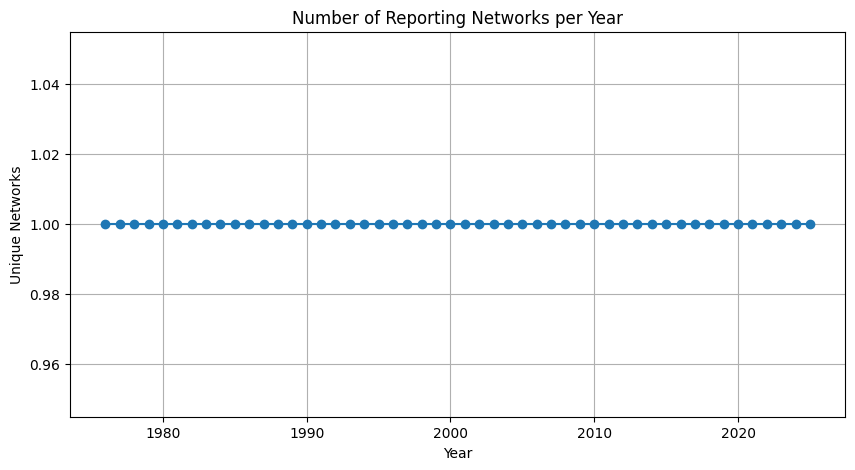

In [69]:
# Track the number of unique reporting networks per year
station_counts = region_df.groupby('year')['net'].nunique()

plt.figure(figsize=(10,5))
plt.plot(station_counts.index, station_counts.values, marker='o')
plt.title("Number of Reporting Networks per Year")
plt.xlabel("Year")
plt.ylabel("Unique Networks")
plt.grid(True)
plt.show()

## 10. Statistical Significance Testing

### Formal Statistical Analysis

**Research Question:** Are observed changes statistically significant?

**Tests performed:**

1. **Poisson Test (Event Rate)**
   - Tests if the current year's earthquake count differs significantly from the historical average.
   - Assumes earthquakes follow a Poisson distribution.
   - **Low p-value (<0.05)**: Significant change in frequency.

2. **Kolmogorov-Smirnov Test (Magnitude Distribution)**
   - Compares magnitude distributions between periods.
   - Tests if distributions are drawn from the same underlying population.
   - **Low p-value (<0.05)**: Significant shift in magnitude patterns.

3. **Kolmogorov-Smirnov Test (Depth Distribution)**
   - Similar to the magnitude test, but for earthquake depths.
   - **Low p-value (<0.05)**: Significant change in depth characteristics.

4. **Energy Comparison**
   - Compares total seismic energy release.
   - Not a formal test, but provides context for magnitude changes.

**Interpretation guidelines:**
- **p < 0.05**: Statistically significant (conventional threshold).
- **p < 0.01**: Highly significant.
- **p > 0.05**: No significant difference detected.
- **Note**: Statistical significance ≠ practical significance.
  - Small changes can be statistically significant with enough data.
  - Focus on effect size, not just p-values.

In [70]:
# Perform statistical tests to assess significance of observed changes
print("\n------- Statistical Tests -------")

# Define previous years and current year dataframes
prev_years_df = region_df[region_df['year'] < current_year]
current_df = region_df[region_df['year'] == current_year]

# 1) Poisson test for event count change
lambda_prev = prev_years_df.groupby('year').size().mean()
count_current = len(current_df)

# Poisson probability of observing count_current given lambda_prev
p_value_poisson = poisson.pmf(count_current, lambda_prev)

print(f"Poisson test (count anomaly): p = {p_value_poisson:.4f}")
if p_value_poisson < 0.05:
    print(" -> Significant change in event count compared to historical average.")

# 2) KS test on magnitude distribution
if len(current_df) > 1 and len(prev_years_df) > 1:
    ks_stat, ks_p = ks_2samp(current_df['mag'], prev_years_df['mag'])
    print(f"KS test (magnitude distribution): p = {ks_p:.4f}")
    if ks_p < 0.05:
        print(" -> Significant difference in magnitude distribution.")
else:
    print("Not enough data for KS magnitude test.")

# 3) KS test on depth distribution
if len(current_df) > 1 and len(prev_years_df) > 1:
    ks_stat_d, ks_p_d = ks_2samp(current_df['depth'].dropna(), prev_years_df['depth'].dropna())
    print(f"KS test (depth distribution): p = {ks_p_d:.4f}")
    if ks_p_d < 0.05:
        print(" -> Significant difference in depth distribution.")
else:
    print("Not enough data for KS depth test.")

# 4) Energy comparison
if len(current_df) > 0:
    energy_current = current_df['energy_joules'].sum()
    energy_prev_avg = prev_years_df.groupby('year')['energy_joules'].sum().mean()
    print(f"Energy this year: {energy_current:.2e} J, Previous years' average: {energy_prev_avg:.2e} J")

print("--------------------------------")


------- Statistical Tests -------
Poisson test (count anomaly): p = 0.1024
KS test (magnitude distribution): p = 0.6133
KS test (depth distribution): p = 0.0005
 -> Significant difference in depth distribution.
Energy this year: 2.59e+13 J, Previous years' average: 1.57e+13 J
--------------------------------


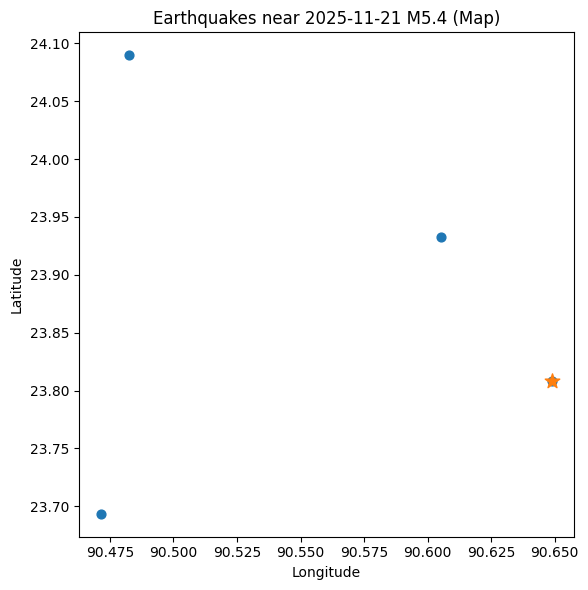

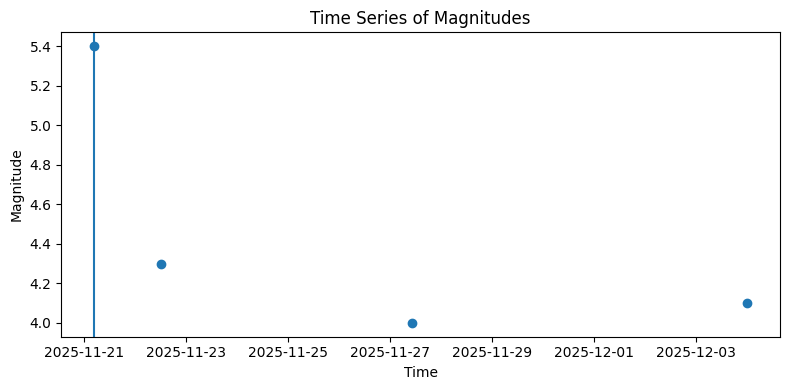

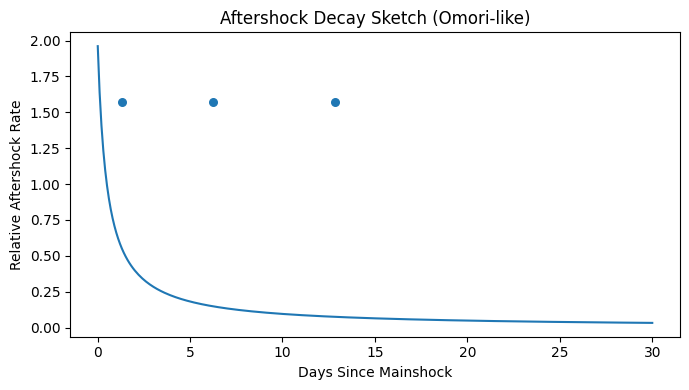

In [71]:
from datetime import timedelta

# Mainshock info
main_time = pd.to_datetime("2025-11-21T04:38:28.765Z")
main_lat, main_lon = 23.8079, 90.6489

# Subset: ±0.6° and time window 30 days after
win = df[
    (df['time'] >= main_time - timedelta(days=1)) &
    (df['time'] <= main_time + timedelta(days=30)) &
    (df['latitude'].between(main_lat-0.6, main_lat+0.6)) &
    (df['longitude'].between(main_lon-0.6, main_lon+0.6))
].copy()

# Compute time since mainshock (days)
win['days_since'] = (win['time'] - main_time).dt.total_seconds() / 86400

# Separate mainshock
aft = win[win['mag'] < 5.4].copy()

# --- Figure 1: Map ---
plt.figure(figsize=(6,6))
plt.scatter(win['longitude'], win['latitude'], s=40)
plt.scatter(main_lon, main_lat, s=120, marker='*')
plt.title("Earthquakes near 2025-11-21 M5.4 (Map)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# --- Figure 2: Time series ---
plt.figure(figsize=(8,4))
plt.plot(win['time'], win['mag'], marker='o', linestyle='none')
plt.axvline(main_time)
plt.title("Time Series of Magnitudes")
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

# --- Figure 3: Aftershock probability sketch (Omori-like curve) ---
# Simple Omori: rate ~ 1/(c+t)
t = np.linspace(0.01, 30, 300)
c = 0.5
k = 1.0
rate = k / (c + t)

plt.figure(figsize=(7,4))
plt.plot(t, rate)
plt.scatter(aft['days_since'], np.full(len(aft), rate.max()*0.8), s=30)
plt.title("Aftershock Decay Sketch (Omori-like)")
plt.xlabel("Days Since Mainshock")
plt.ylabel("Relative Aftershock Rate")
plt.tight_layout()
plt.show()

In [72]:
# Mainshock info
main_time = pd.to_datetime("2025-11-21T04:38:28.765Z")
main_lat, main_lon = 23.8079, 90.6489

# Window: ±0.6 deg, 30 days after
win = df[
    (df['time'] >= main_time) &
    (df['time'] <= main_time + timedelta(days=30)) &
    (df['latitude'].between(main_lat-0.6, main_lat+0.6)) &
    (df['longitude'].between(main_lon-0.6, main_lon+0.6))
].copy()

# Aftershocks only
aft = win[win['mag'] < 5.4].copy()

# Time since mainshock
aft['days_since'] = (aft['time'] - main_time).dt.total_seconds() / 86400

# --- Fit simple Omori for total aftershock count ---
c = 0.5   # days
T = 30.0  # days
N_obs = len(aft)

k = N_obs / np.log((c + T) / c) if N_obs > 0 else 0.0

# --- Estimate b-value from aftershocks ---
if len(aft) > 1:
    Mmin = aft['mag'].min()
    meanM = aft['mag'].mean()
    b = (np.log10(np.e)) / (meanM - Mmin + 0.05)
else:
    b = np.nan
    Mmin = np.nan

# Forecast number of M>=4 using GR scaling
def forecast_m_ge(m):
    if np.isnan(b):
        return np.nan
    scale = 10 ** (-b * (m - Mmin))
    # expected total aftershocks in window 0–T
    N_total = N_obs
    # project same rate forward: in 7 or 30 days ahead from now
    return N_total * scale

forecast_7 = forecast_m_ge(4)
forecast_30 = forecast_m_ge(4)

# Build table
table = pd.DataFrame({
    "Forecast Window": ["Next 7 days", "Next 30 days"],
    "Expected M≥4 Aftershocks": [forecast_7, forecast_30],
    "b_value": [b, b],
    "Mmin_used": [Mmin, Mmin]
})

table

,Forecast Window,Expected M≥4 Aftershocks,b_value,Mmin_used
0,Next 7 days,3.0,2.368879,4.0
1,Next 30 days,3.0,2.368879,4.0


## Summary and Recommendations

**After running all analyses, synthesize findings:**

1. **Temporal trends**: Are earthquake frequencies increasing, decreasing, or stable?
2. **Magnitude patterns**: Any shifts toward stronger or weaker events?
3. **Energy release**: Is cumulative energy release unusual?
4. **Spatial patterns**: New areas of activity or changes in existing patterns?
5. **Depth changes**: Any systematic shifts in earthquake depths?
6. **Clustering**: Evidence of swarms or aftershock sequences?
7. **Detection bias**: How much of the change is due to improved monitoring?
8. **Statistical significance**: Are changes meaningful or within normal variation?

**Key questions to answer:**
- Is the current seismic activity genuinely unusual?
- What are the potential hazard implications?
- Do changes reflect improved detection or real tectonic changes?
- Are there specific regions or magnitude ranges of concern?

**Next steps might include:**
- Focused analysis on specific time periods or regions showing anomalies.
- Consultation with regional seismologists for context.
- Hazard assessment updates if significant changes are detected.
- Continued monitoring of identified trends.